## Quantum Encoding for QG Dataset ##
Using angular encoding

TODO: 
- Fix absolute path
- Try amplitude encoding

In [18]:
from scipy.stats import unitary_group
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pennylane as qml
from pennylane.templates import RandomLayers

seed = 42
filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG_train_normalized_16_xl"

file = h5py.File(filename,"r")
data_X = np.array(h5py.File(filename, "r")['X'])

# plt.imshow(np.mean(file['X'], axis=0), norm=matplotlib.colors.LogNorm())
# plt.colorbar()

num_samples = 80
data_X = np.array(file['X'])

n_layers = 10

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

def haar_random_unitary(seed=None):
    if seed is not None:
        np.random.seed(seed)
    return unitary_group.rvs(8)

def scramble_state_vectors(encoded_data , seed):
    scrambled_vectors = []

    for i in range(num_samples):
        U = haar_random_unitary(seed)

        scrambled_state = np.dot(U, encoded_data[i])
        scrambled_state /= np.linalg.norm(scrambled_state)
        scrambled_vectors.append(scrambled_state)

        if seed is not None:
            seed += 1

    return np.array(scrambled_vectors)

def convert_to_bloch_vector(vector):
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    Z = np.array([[1, 0], [0, -1]])

    ax = np.trace(np.dot(vector, X)).real
    ay = np.trace(np.dot(vector, Y)).real
    az = np.trace(np.dot(vector, Z)).real

    return [ax, ay, az]

# THE PLAN: RESHAPE INTO [num_samples, 64, 2, 2]
# Then convert each 2x2 matrix into 64 bloch vectors 
# Total of num_samples * 64 vectors
def reshape_scrambled_states(scrambled_states):
    reshaped_scrambled_states = []

    # for s in range(num_samples):
    #     for x in range(8):
    #         for y in range(8):
    #             reshaped_scrambled_states.append([scrambled_states[s, x, y, 0:2], scrambled_states[s, x, y, 3:5]])
    reshaped_scrambled_states = scrambled_states.reshape(num_samples, 64, 4)
    reshaped_scrambled_states = scrambled_states.reshape(num_samples, 64, 2, 2)
    return np.array(reshaped_scrambled_states)

def plot_bloch_sphere(bloch_vectors):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    x, y, z = np.array([[-1.5,0,0], [0, -1.5, 0], [0, 0, -1.5]])
    u, v, w = np.array([[3,0,0], [0, 3, 0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(bloch_vectors[:, 0], bloch_vectors[:, 1], bloch_vectors[:, 2], c="#e29d2e", alpha=0.3)

(80, 8, 8, 4)
(80, 64, 2, 2)
(64, 3)


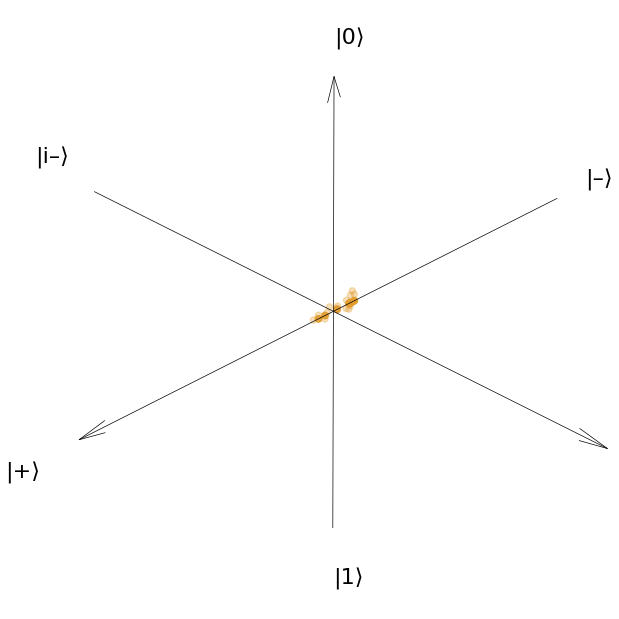

In [19]:
import numpy as np
import pennylane as qml
from pennylane.templates import RandomLayers
import torch
import torch.nn as nn
import torch.optim as optim

data_X = np.array(h5py.File(filename, "r")['X'])

num_qubits = 64
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev)
def angle_circuit(phi):
    for j in range(4):
        qml.RX(np.pi * phi[j], wires=j)
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

def angle_encoding(data, sample=0):
    out = np.zeros((8, 8, 4))
    for i in range(0, 16, 2):
        for j in range(0, 16, 2):
            q_results = angle_circuit(
                [
                    data[sample, i, j],
                    data[sample, i, j+1],
                    data[sample, i+1, j],
                    data[sample, i+1, j+1]
                ]
            )
            for c in range(4):
                out[i//2, j//2, c] = q_results[c]
    return out
def visualize_data(original_data, encoded_data, sample_index=0):
    # original_mean = np.mean(original_data, axis=0)
    original_sample = original_data[sample_index]
    
    plot_figure(original_sample, title="Original Data")

    encoded_sample = encoded_data[sample_index]
    encoded_image = encoded_data
    for channel in range(4):
        encoded_image = encoded_sample[:, :, channel]

        plot_figure(encoded_image, title="Quantum Encoded Data")

def plot_figure(data, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(data, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.show()
    
encoded_data = [angle_encoding(data_X, sample) for sample in range(num_samples)]
encoded_data = np.array(encoded_data)
# visualize_data(data_X, encoded_data, sample_index=0)


scrambled_states = scramble_state_vectors(np.array(encoded_data), seed)
# scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32)
# visualize_data(data_X, scrambled_states, sample_index=0)
# visualize_data(data_X, scrambled_states, sample_index=1)

encoded_data = torch.tensor(encoded_data, dtype=torch.float32)


print(scrambled_states.shape)

reshaped_scrambled_states = reshape_scrambled_states(scrambled_states)
print(reshaped_scrambled_states.shape)

# Bloch vectors for the first 64 points only
scrambled_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in reshaped_scrambled_states[0]])
print(scrambled_bloch_vectors.shape)
plot_bloch_sphere(scrambled_bloch_vectors)


In [7]:
# class QuantumLayer(nn.Module):
#     def __init__(self, n_qubits, n_layers, n_outputs):
#         super(QuantumLayer, self).__init__()
#         self.n_qubits = n_qubits
#         self.n_layers = n_layers
#         self.weight_shapes = {"weights": (n_layers, n_qubits)}
#         self.dev = qml.device("default.qubit", wires=n_qubits)
#         self.qnode = qml.QNode(self.circuit, self.dev)
#         self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

#     def circuit(self, weights):
#         for layer in weights:
#             for i in range(self.n_qubits):
#                 qml.RY(layer[i], wires=i)
#         return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

#     def forward(self, x):
#         batch_size = x.shape[0]
#         q_out = torch.zeros(batch_size, self.n_qubits)
#         for i in range(batch_size):
#             q_out[i] = torch.tensor(self.qnode(self.q_params))
#         return q_out

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers, n_outputs):
        super(QuantumLayer, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weight_shapes = {"weights": (n_layers, n_qubits)}
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)
        self.q_params = nn.Parameter(torch.randn(n_layers, n_qubits))

    def circuit(self, weights):
        for layer in weights:
            for i in range(self.n_qubits):
                qml.RY(layer[i], wires=i)
                qml.RZ(layer[i], wires=i)
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[self.n_qubits - 1, 0])  # Connect the last qubit to the first

        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

    def forward(self, x):
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, self.n_qubits)
        for i in range(batch_size):
            q_out[i] = torch.tensor(self.qnode(self.q_params))
        return q_out

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, n_qubits)
        self.dropout2 = nn.Dropout(0.1)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers, n_qubits)
        self.fc3 = nn.Linear(n_qubits, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.quantum_layer(x)
        x = self.fc3(x)
        return x
    
# No Quantum Layer DM
# class DiffusionModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
#         super(DiffusionModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4
n_qubits = 16
n_layers = 1

model = DiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model)

DiffusionModel(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (quantum_layer): QuantumLayer()
  (fc3): Linear(in_features=16, out_features=256, bias=True)
)


In [8]:
num_epochs = 50
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(scrambled_states.view(num_samples, -1))
    loss = criterion(outputs, encoded_data.view(num_samples, -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Epoch [1/50], Loss: 1.0241


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.58834..1.0869739].


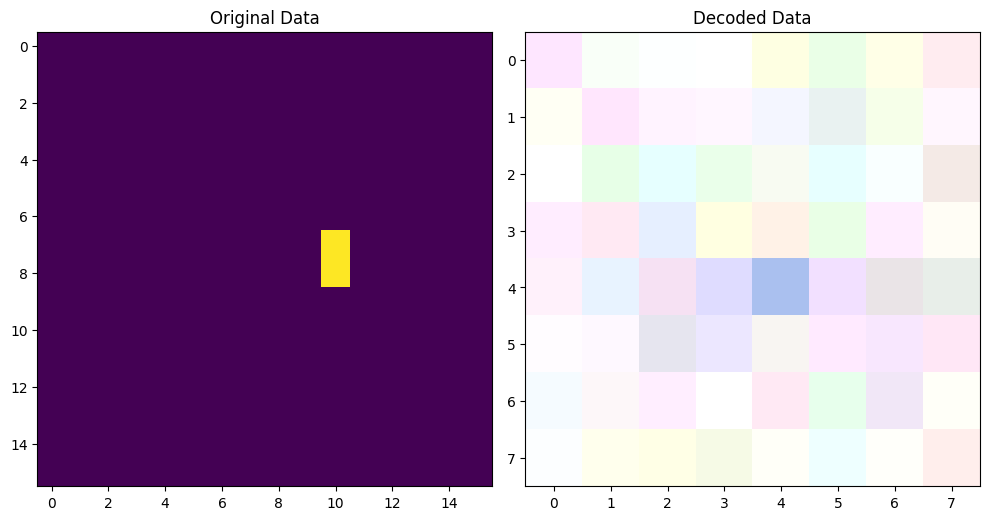

In [34]:
denoised_states = model(scrambled_states.view(num_samples, -1))
denoised_states = denoised_states.view(num_samples, 8, 8, 4).detach().numpy()
visualize_data(data_X, denoised_states, sample_index=0)

(80, 8, 8, 4)
(100000, 16, 16)
(80, 16, 16)


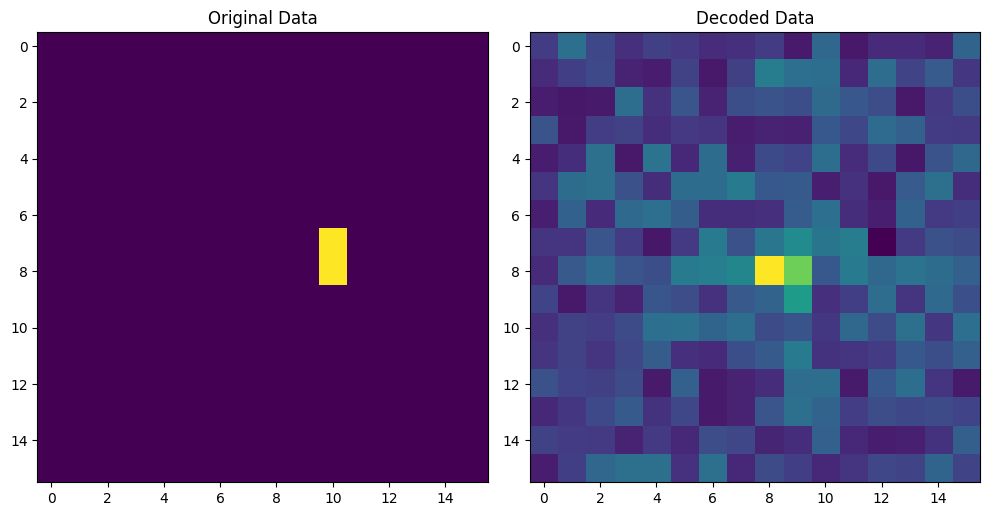

In [35]:
print(denoised_states.shape)
print(data_X.shape)

# Decode [num_samples, 8, 8, 4] into 1 channel [num_samples, 16, 16]
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_qubits = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_qubits):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

def visualize_data(original_data, decoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(decoded_data[sample_index], cmap='viridis')
    axes[1].set_title("Decoded Data")
    
    plt.tight_layout()
    plt.show()

decoded_data = decode(denoised_states)
decoded_data = flip(decoded_data)
print(decoded_data.shape)

visualize_data(data_X, decoded_data, sample_index=0)

In [36]:
import scipy.linalg

def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):

    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid


# These don't work yet
def compute_kernel(x, y, kernel='rbf', sigma=1.0):
    if kernel == 'rbf':
        # RBF kernel (Gaussian kernel)
        x_size = x.shape[0]
        y_size = y.shape[0]
        dim = x.shape[1]
        
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        
        return torch.exp(-torch.mean((tiled_x - tiled_y) ** 2, dim=2) / (2 * sigma ** 2))
    else:
        raise ValueError(f"Unknown kernel type: {kernel}")

def mmd(x, y, kernel='rbf', sigma=1.0):
    x = torch.tensor(x)
    y = torch.tensor(y)
    
    xx = compute_kernel(x, x, kernel, sigma)
    yy = compute_kernel(y, y, kernel, sigma)
    xy = compute_kernel(x, y, kernel, sigma)
    
    return torch.mean(xx) + torch.mean(yy) - 2 * torch.mean(xy)


mu1, sigma1 = calculate_statistics(data_X)
mu2, sigma2 = calculate_statistics(decoded_data)

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f"FID score: {fid}")

flat_data_X = data_X.reshape(data_X.shape[0], -1)
flat_decoded_data = decoded_data.reshape(decoded_data.shape[0], -1)

# mmd_score = mmd(flat_data_X, flat_decoded_data)
# print(f"MMD Score: {mmd_score.item()}")


FID score: 2.381481123794865


c:\Users\realc\OneDrive\Documents\GSOC\.venv\Lib\site-packages\scipy\linalg\_matfuncs_sqrtm.py:209: RuntimeWarning: invalid value encountered in scalar divide
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


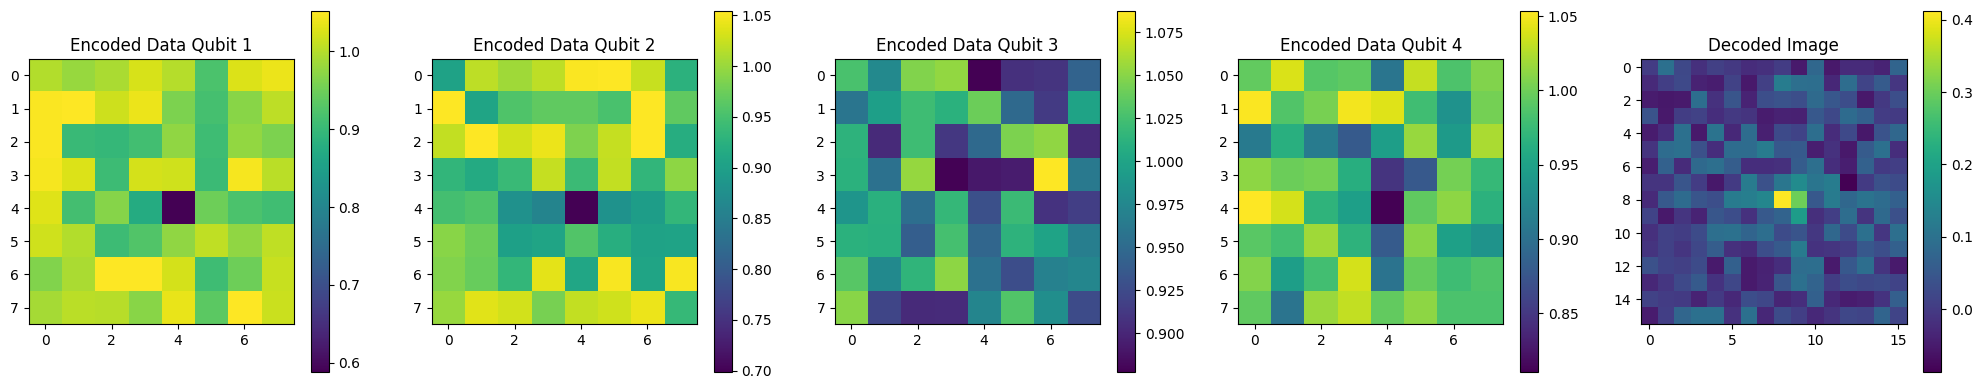

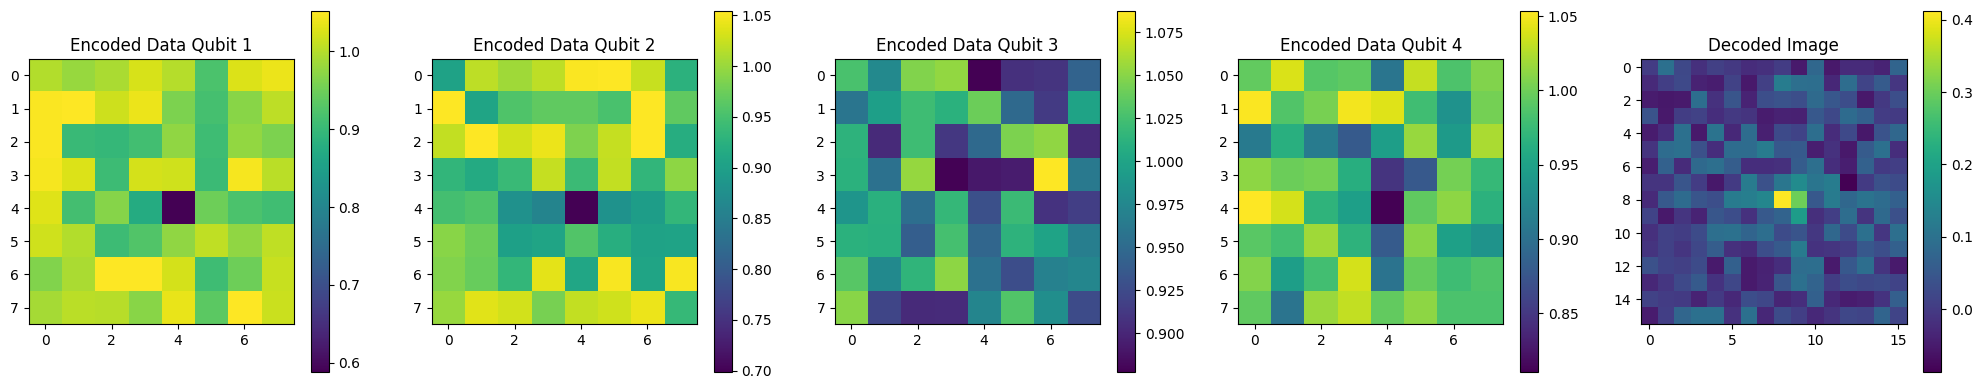

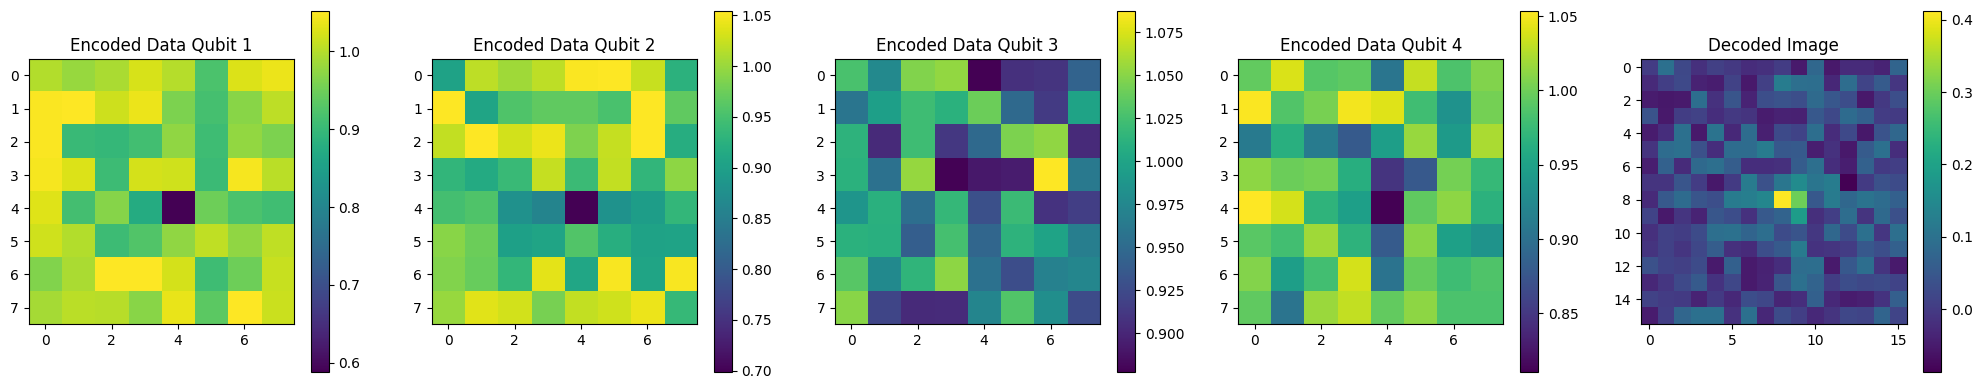

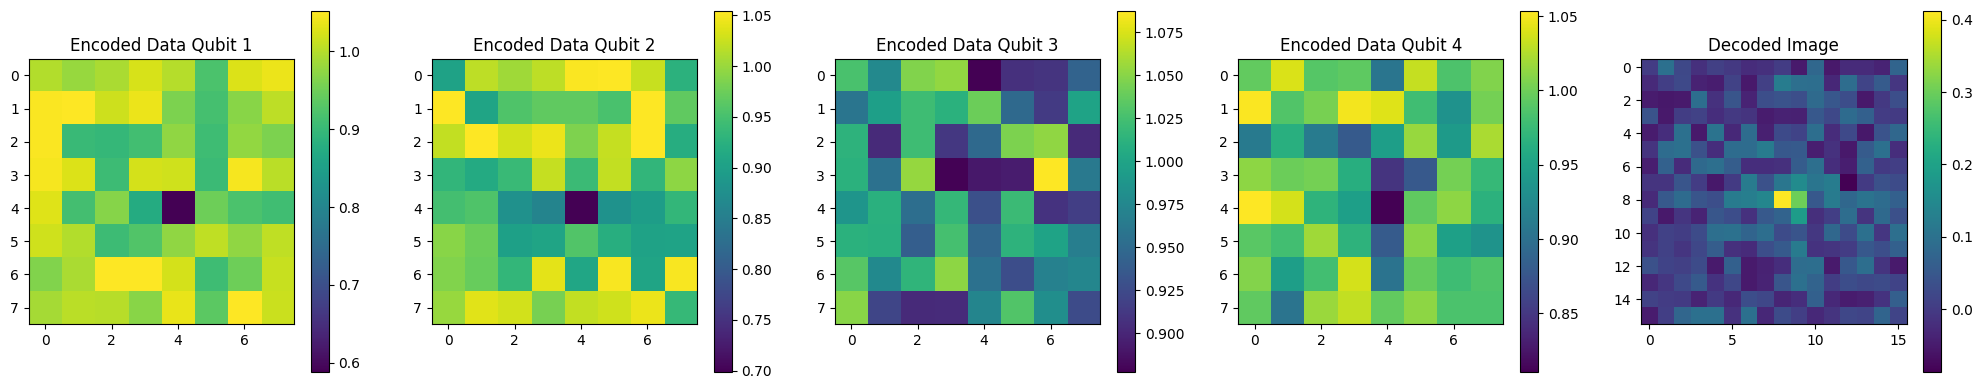

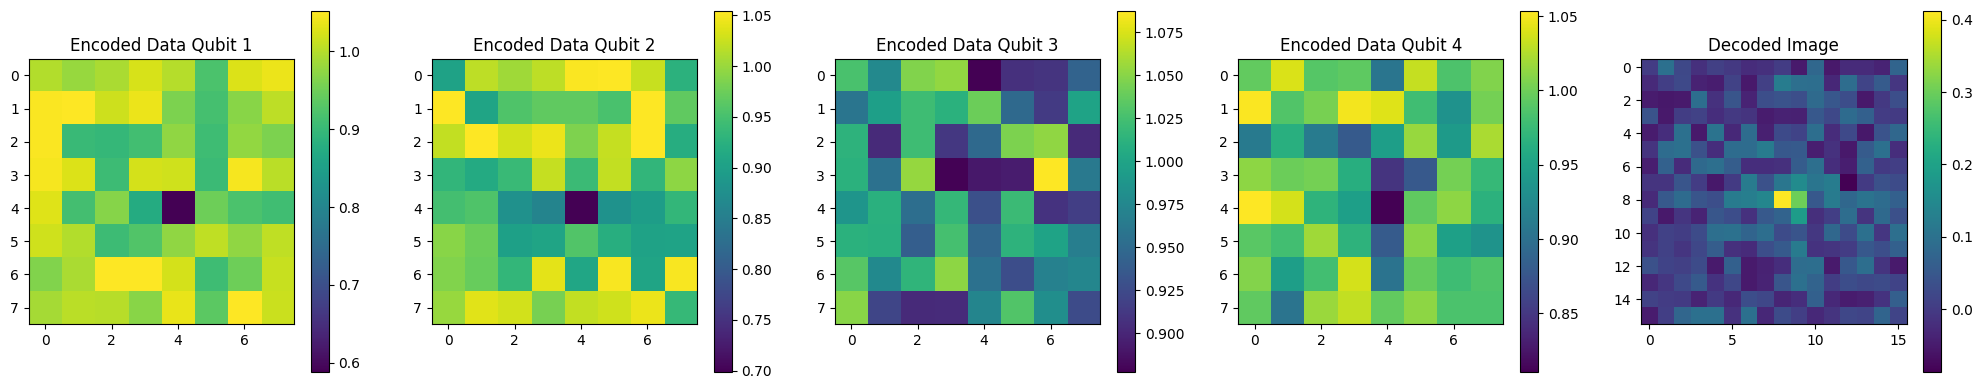

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming the DiffusionModel and trained model are already defined and trained as given

# Function to generate new images
def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))

            # Display each channel separately
            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded Data Qubit {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            # Combined visualization (if applicable)
            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded Image")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images


num_new_images = 5
new_images = generate_new_images(model, num_new_images)


In [ ]:
def calculate_fid(real_images, fake_images, batch_size=128):
    inception_model = models.inception_v3(pretrained=True, transform_input=False).cuda()
    inception_model.eval()

    def get_features(images):
        features = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].cuda()
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            batch = batch.repeat(1, 3, 1, 1)
            with torch.no_grad():
                pred = inception_model(batch)
            features.append(pred.cpu().numpy())
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    if sigma1.ndim == 0:
        sigma1 = np.array([[sigma1]])
    if sigma2.ndim == 0:
        sigma2 = np.array([[sigma2]])

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid